In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import sys
from IPython.display import display

In [3]:
def on_kaggle() -> bool:
    try:
        import gresearch_crypto
        return True
    except ModuleNotFoundError:
        return False

In [4]:
# HYPER PARAMETERS
ON_KAGGLE = on_kaggle()
SAMPLE_LEVEL = 0
FORCE_REWRITE = True

In [5]:
if not ON_KAGGLE and os.path.abspath('.').endswith('notebook'):
    os.chdir('../')

In [6]:
#IMPORT_SCRIPT!
if not ON_KAGGLE and '.' not in sys.path:
    sys.path.append('.')
from src.metrics import *
from src.data import merge_asset_details
from src.cv import TimeSeriesSplit, get_date_range
from src.modeling import Evaluator
from src.metrics import compute_metrics, compute_correlation
from src.pipeline.feature_gen import compute_instant_features
from src.data import infer_dtypes
from src.pipeline import EXPECTED_RAW_COLS
from src.pipeline.transforms import FilterFeatures
from src.modeling import Evaluator
from src.util import setup_dir

In [7]:
DATA_DIR, RAW_TRAIN_DIR = setup_dir(ON_KAGGLE, sample_level=SAMPLE_LEVEL)
RAW_TRAIN_PATH = RAW_TRAIN_DIR / 'train.csv'
ASSET_DETAILS_PATH = DATA_DIR / 'asset_details.csv'

In [8]:
RAW_TRAIN_DIR

PosixPath('data/raw')

In [9]:
DATA_DIR

PosixPath('data/raw')

In [10]:
%%time 
raw_data = pd.read_csv(RAW_TRAIN_PATH)

CPU times: user 50.4 s, sys: 5.7 s, total: 56.1 s
Wall time: 1min 4s


## create train set

In [11]:
MAIN_INDEX = ['timestamp', 'Asset_ID']

In [12]:
# get valid data only, drop where the target is NaN 
raw_data = raw_data.dropna(subset=['Target'])
# format time to human readable 
raw_data['time'] = pd.to_datetime(raw_data['timestamp'], unit='s')
# merge asset names
raw_data = merge_asset_details(raw_data, ASSET_DETAILS_PATH)

In [13]:
raw_data.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,time,Asset_Name
0,1514764860,2,40.0,2376.5800,2399.5000,2357.1400,2374.5900,19.233005,2373.116392,-0.004218,2018-01-01 00:01:00,Bitcoin Cash
1,1514764860,0,5.0,8.5300,8.5300,8.5300,8.5300,78.380000,8.530000,-0.014399,2018-01-01 00:01:00,Binance Coin
2,1514764860,1,229.0,13835.1940,14013.8000,13666.1100,13850.1760,31.550062,13827.062093,-0.014643,2018-01-01 00:01:00,Bitcoin
3,1514764860,5,32.0,7.6596,7.6596,7.6567,7.6576,6626.713370,7.657713,-0.013922,2018-01-01 00:01:00,EOS.IO
4,1514764860,7,5.0,25.9200,25.9200,25.8740,25.8770,121.087310,25.891363,-0.008264,2018-01-01 00:01:00,Ethereum Classic


In [14]:
raw_data.tail()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,time,Asset_Name
23486463,1632181440,9,163.0,156.502000,156.620000,156.000000,156.075667,7.381963e+02,156.260253,-0.001154,2021-09-20 23:44:00,Litecoin
23486464,1632181440,10,23.0,2420.146667,2421.000000,2412.779000,2414.069667,1.315794e+00,2417.326038,0.009831,2021-09-20 23:44:00,Maker
23486465,1632181440,13,512.0,0.090989,0.091133,0.090831,0.090885,1.900695e+06,0.090943,0.004163,2021-09-20 23:44:00,TRON
23486466,1632181440,12,193.0,0.280952,0.281300,0.280175,0.280403,1.628699e+05,0.280655,0.000449,2021-09-20 23:44:00,Stellar
23486467,1632181440,11,38.0,232.075000,232.300000,231.310000,231.680000,4.914804e+01,231.794078,0.002568,2021-09-20 23:44:00,Monero


In [15]:
raw_data = infer_dtypes(raw_data)

In [16]:
raw_data.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,time,Asset_Name
0,1514764860,2,40.0,2376.580078,2399.500000,2357.139893,2374.590088,19.233005,2373.116455,-0.004218,2018-01-01 00:01:00,Bitcoin Cash
1,1514764860,0,5.0,8.530000,8.530000,8.530000,8.530000,78.380000,8.530000,-0.014399,2018-01-01 00:01:00,Binance Coin
2,1514764860,1,229.0,13835.194336,14013.799805,13666.110352,13850.175781,31.550062,13827.062500,-0.014643,2018-01-01 00:01:00,Bitcoin
3,1514764860,5,32.0,7.659600,7.659600,7.656700,7.657600,6626.713370,7.657713,-0.013922,2018-01-01 00:01:00,EOS.IO
4,1514764860,7,5.0,25.920000,25.920000,25.874001,25.877001,121.087310,25.891363,-0.008264,2018-01-01 00:01:00,Ethereum Classic


In [17]:
FEATURES = [
'Count',
'High',
'Low',
'Close',
'Volume',
'VWAP',
'high_low_return',
'open_close_return',
'upper_shadow',
'lower_shadow',
'dolar_amount',
'vol_per_trades'
]

In [18]:
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from lightgbm import LGBMRegressor, LGBMClassifier


class LGBMProfit(LGBMClassifier):
    def fit(self, X, y, *args, **kwargs):
        profit = y >= 0
        self.mean = profit.mean()
        return super().fit(X, profit, *args, **kwargs)

    def predict(self, X):
        proba = self.predict_proba(X)[:, 1]
        return proba - self.mean

def build_model(params={'alpha': 0.001}):
#     model = Pipeline([('filter', FilterFeatures(FEATURES)),
#                       ('norm', MinMaxScaler()),
#                       ('model', Ridge(params['alpha'], random_state=1))])
    model = Pipeline([('filter', FilterFeatures(FEATURES)),
                      ('model', LGBMProfit())])
    return model

In [19]:
def train_model(config, train_data, valid_data, pipeline=None):
    model  = build_model(config['model'])

    if config['training']['time_decay_alpha'] is not None:
        time_decay_alpha = config['training']['time_decay_alpha']
        print(f'using exponential_time_decay with alpha {time_decay_alpha}')
        timesteps = ((train_data['timestamp'].max() - train_data['timestamp'])//60//60//24)
        weight = time_decay_alpha ** timesteps
    else:
        weight = None

    model.fit(train_data, train_data['Target'], model__sample_weight=weight)
    return model


def get_mask_for_asset(data: pd.DataFrame, asset_id: int):
    return (data['Asset_ID'] == asset_id)


def get_data_for_asset(data: pd.DataFrame, asset_id: int):
    mask = get_mask_for_asset(data, asset_id)
    return data.loc[mask, :].reset_index(drop=True)

In [20]:
PRIVATE_LB_RANGE = [['2020-01-01', '2020-04-01']]
PULIC_LB_RANGE = ['2021-06-13',
                  '2021-09-13'] # 3 MONTH WORTH OF DATA


if SAMPLE_LEVEL==2:
    EVAL_PERIODS = [['2021-09-11', '2021-09-13']]
elif SAMPLE_LEVEL == 1:
    EVAL_PERIODS = [PULIC_LB_RANGE]
else:
    EVAL_PERIODS =  [
                     ['2020-01-01', '2020-04-01'],
                     ['2020-09-01', '2021-01-01'],
                     ['2021-01-01', '2021-04-01'],
                     ['2021-04-01', '2021-07-01']
                     ]

In [21]:
EVAL_PERIODS

[['2020-01-01', '2020-04-01'],
 ['2020-09-01', '2021-01-01'],
 ['2021-01-01', '2021-04-01'],
 ['2021-04-01', '2021-07-01']]

In [22]:
def _create_fi_pd(features, importances):
    return (pd.DataFrame({'feature': features, 'importance': importances})
            .sort_values(by=['importance']).reset_index(drop=True))

def compute_fi(config, model, valid_data):
    return _create_fi_pd(model['filter'].features, model['model'].feature_importances_)

In [23]:
CV_PARAMS = {'gap_unit': 'min', 'dt_col': 'time'}


CV = TimeSeriesSplit(EVAL_PERIODS, **CV_PARAMS)
asset_ids = raw_data['Asset_ID'].unique()

def run(config, raw_data: pd.DataFrame):
    evaluator = Evaluator(cv=CV, fi_fn=compute_fi)
    
    data = raw_data.copy()
    data = compute_instant_features(data)
    data.fillna(0, inplace=True)
    RESULTS = {}
    for asset_id in asset_ids:
        asset_data = get_data_for_asset(data, asset_id)
        asset_result = evaluator.run(train_model, config, asset_data)
        RESULTS[asset_id] = asset_result 
    return RESULTS

In [24]:
MODEL_CONFIG = {'alpha': 0.001}
TRAIN_CONFIG = {'time_decay_alpha': None}
CONFIG = {'model': MODEL_CONFIG, 'training': TRAIN_CONFIG}

In [25]:
import itertools

In [26]:
RESULTS = run(CONFIG, raw_data)

fold=0
elapsed time: 0.0630
fold=1
elapsed time: 0.0830
fold=2
elapsed time: 0.0773
fold=3
elapsed time: 0.0828
fold=0
elapsed time: 0.0478
fold=1
elapsed time: 0.1285
fold=2
elapsed time: 0.0834
fold=3
elapsed time: 0.0790
fold=0
elapsed time: 0.0506
fold=1
elapsed time: 0.0668
fold=2
elapsed time: 0.0863
fold=3
elapsed time: 0.0989
fold=0
elapsed time: 0.0519
fold=1
elapsed time: 0.0723
fold=2
elapsed time: 0.0751
fold=3
elapsed time: 0.0903
fold=0
elapsed time: 0.0479
fold=1
elapsed time: 0.0696
fold=2
elapsed time: 0.0872
fold=3
elapsed time: 0.0990
fold=0
elapsed time: 0.0525
fold=1
elapsed time: 0.0657
fold=2
elapsed time: 0.0740
fold=3
elapsed time: 0.0929
fold=0
elapsed time: 0.0495
fold=1
elapsed time: 0.0679
fold=2
elapsed time: 0.0783
fold=3
elapsed time: 0.0825
fold=0
elapsed time: 0.0350
fold=1
elapsed time: 0.0852
fold=2
elapsed time: 0.0701
fold=3
elapsed time: 0.0646
fold=0
elapsed time: 0.0528
fold=1
elapsed time: 0.0709
fold=2
elapsed time: 0.0737
fold=3
elapsed time:

In [27]:
inference_df = pd.concat(itertools.chain(*[asset_result['prediction'] for _, asset_result in RESULTS.items()]))
scores = inference_df.groupby('fold').apply(compute_metrics).reset_index()
scores['eval_period'] = EVAL_PERIODS

In [28]:
scores

,fold,corr,crypto_consistency,sharpe,corr_period_mean,corr_period_std,consistency,min_period_corr,corr_min,corr_max,corr_std,eval_period
0,0,0.011571,10.0,2.051196,0.013529,0.006596,1.000000,0.003143,-0.085745,0.042866,0.032039,"[2020-01-01, 2020-04-01]"
1,1,0.001306,11.0,-0.035802,-0.000403,0.011260,0.500000,-0.028695,-0.010744,0.025228,0.009505,"[2020-09-01, 2021-01-01]"
2,2,0.000278,9.0,0.338149,0.004642,0.013729,0.769231,-0.025800,-0.011300,0.025934,0.010428,"[2021-01-01, 2021-04-01]"
3,3,0.001879,11.0,0.106501,0.000947,0.008891,0.615385,-0.023019,-0.022536,0.022184,0.011727,"[2021-04-01, 2021-07-01]"


In [30]:
print('|    |   fold |       corr |   crypto_consistency |      sharpe |   corr_period_mean |\n|---:|-------:|-----------:|---------------------:|------------:|-------------------:|\n|  0 |      0 | 0.0340875  |                   12 |  0.891724   |        0.0140149   |\n|  1 |      1 | 0.00107583 |                   11 | -0.00378112 |       -6.72739e-05 |\n|  2 |      2 | 0.00639626 |                   10 |  0.730508   |        0.0114782   |\n|  3 |      3 | 0.00803942 |                   10 |  0.333772   |        0.00654437  |')

|    |   fold |       corr |   crypto_consistency |      sharpe |   corr_period_mean |
|---:|-------:|-----------:|---------------------:|------------:|-------------------:|
|  0 |      0 | 0.0340875  |                   12 |  0.891724   |        0.0140149   |
|  1 |      1 | 0.00107583 |                   11 | -0.00378112 |       -6.72739e-05 |
|  2 |      2 | 0.00639626 |                   10 |  0.730508   |        0.0114782   |
|  3 |      3 | 0.00803942 |                   10 |  0.333772   |        0.00654437  |


In [31]:
scores.mean()

fold                   1.500000
corr                   0.003759
crypto_consistency    10.250000
sharpe                 0.615011
corr_period_mean       0.004679
corr_period_std        0.010119
consistency            0.721154
min_period_corr       -0.018593
corr_min              -0.032581
corr_max               0.029053
corr_std               0.015925
dtype: float64

fold                   1.500000
corr                   0.012400
crypto_consistency    10.750000
sharpe                 0.488056
corr_period_mean       0.007993
corr_period_std        0.017207
consistency            0.768162
min_period_corr       -0.018003
corr_min              -0.027406
corr_max               0.064634
corr_std               0.023568
dtype: float64

In [32]:
corrs_fold = inference_df.groupby('fold').apply(lambda d: compute_correlation(d, group_col='Asset_Name').set_index("Asset_Name")).unstack().T

corrs_fold['cum_corr'] = corrs_fold.mean(axis=1)

In [33]:
corrs_fold = corrs_fold.sort_values(by='cum_corr')

In [34]:
corrs_fold

fold                          0         1         2         3  cum_corr
     Asset_Name                                                        
corr Maker            -0.085745  0.015102  0.005385  0.006789 -0.014617
     Dogecoin         -0.006977 -0.003316 -0.011300  0.001318 -0.005069
     Bitcoin           0.013743 -0.007828  0.000939 -0.022536 -0.003920
     TRON              0.012688 -0.010744 -0.000155  0.014510  0.004075
     Ethereum Classic  0.005033  0.002667  0.015756 -0.006410  0.004262
     Cardano          -0.003918  0.007472  0.008050  0.005841  0.004362
     Binance Coin     -0.000815  0.013560  0.015540  0.005380  0.008416
     Monero            0.005989  0.006761  0.002685  0.021294  0.009182
     EOS.IO            0.036321  0.008778 -0.006216  0.000602  0.009871
     Stellar           0.011474  0.008849  0.017916  0.008145  0.011596
     IOTA              0.006290  0.025228  0.006593  0.015945  0.013514
     Ethereum          0.042866  0.010986 -0.006329  0.015879  0.015850
     Litecoin          0.037013  0.009159  0.025934  0.004070  0.019044
     Bitcoin Cash      0.042224  0.013839  0.008884  0.022184  0.021783

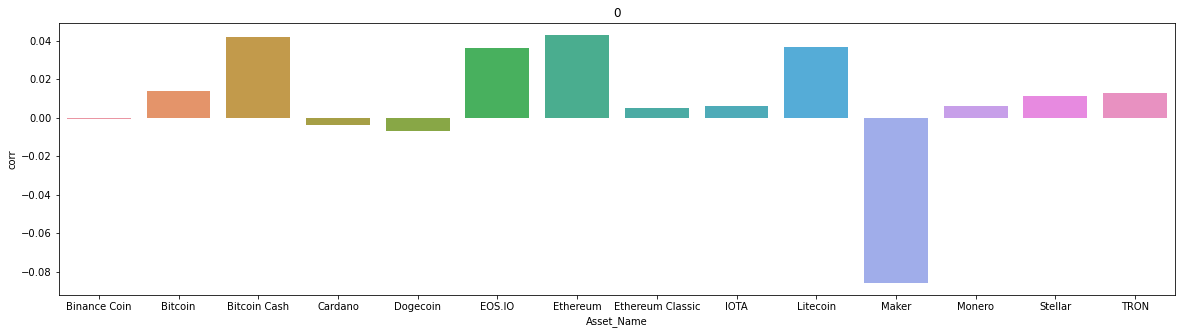

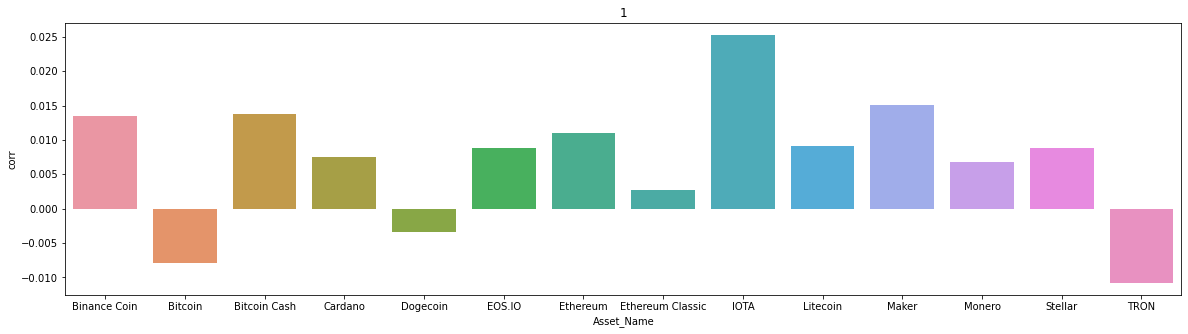

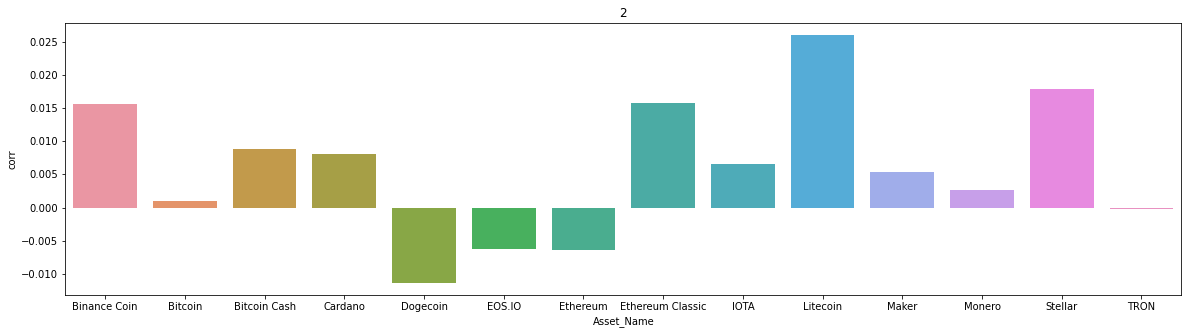

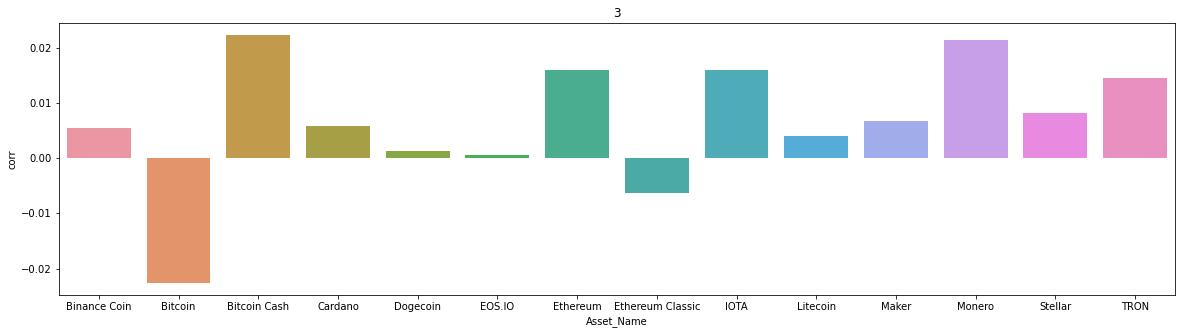

In [35]:
for fold, fold_data in inference_df.groupby('fold'):
    corrs = compute_correlation(fold_data, group_col='Asset_Name')
    plt.figure(figsize=(20, 5))
    sns.barplot(x='Asset_Name', y='corr', data=corrs)
    plt.title(fold)